# SHAP explanations

In [1]:
from trustyai.utils import TestModels
from trustyai.model import feature, output, Model, Dataset
from trustyai.model import simple_prediction
from trustyai.explainers import SHAPExplainer

import pandas as pd
import random

%pip install -r ../requirements-examples.txt --quiet


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Python Models
Now let's go over how to use a Python model with TrustyAI. First, let's grab a dataset, we'll use the California Housing dataset from `sklearn`, which tries
to predict the median house value of various California housing districts given a number of different attributes of the district.

After downloading the dataset, we then split it into train and test splits.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.fetch_california_housing(data_home="data", return_X_y=True, as_frame=True)
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
print(f"X Train: {X_train.shape}, X Test: {X_test.shape}, Y Train: {y_train.shape}, Y Test: {y_test.shape}")

X Train: (16512, 8), X Test: (4128, 8), Y Train: (16512, 1), Y Test: (4128, 1)


Now let's grab our model, just a simple xgboost regressor. We'll then plot its test predictions against the the true test labels, to see how well it does.

Test MSE 0.9144258310736139


/home/rui/.virtualenvs/trustyai-explainability-python-examples/lib/python3.11/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


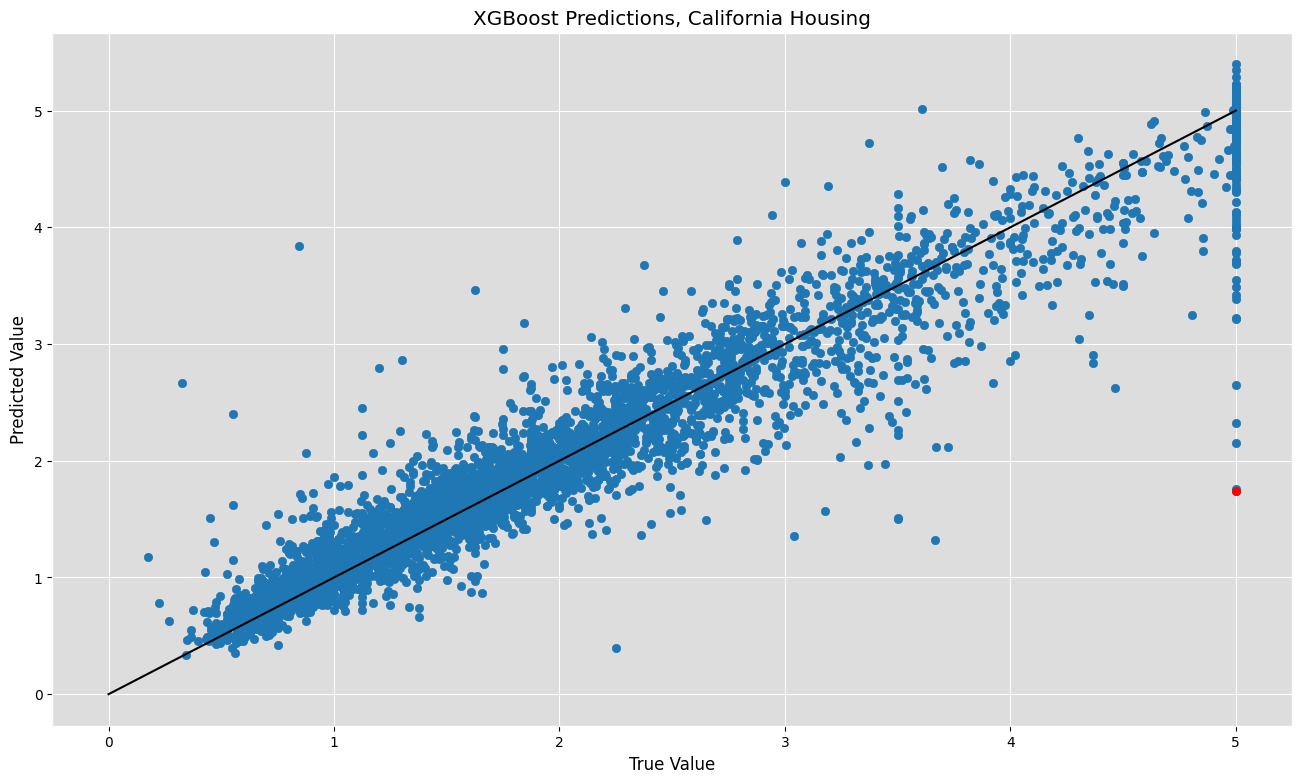

In [3]:
import xgboost
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('../styles/material_rh.mplstyle')

# uncomment to train from scratch
# xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist')
# xgb_model.fit(X_train, y_train)
# print('Test MSE', xgb_model.score(X_test, y_test))
# xgb_model.save_model("models/california_xgboost")
 
# load and score model
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
xgb_model.load_model("models/california_xgboost")
print('Test MSE', xgb_model.score(X_test, y_test))

# grab predictions and find largest error
predictions = xgb_model.predict(X_test)
worst = np.argmax(np.abs(predictions - y_test['MedHouseVal'].values))

# plot predictions
plt.scatter(y_test, predictions)
plt.scatter(y_test['MedHouseVal'].iloc[worst], predictions[worst], color='r')
plt.plot([0,5], [0,5], color='k')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("XGBoost Predictions, California Housing")
plt.show()

That's pretty decent! Let's grab a point to explain; let's choose that really erroneous point marked in red in the above plot.

In [4]:
point_to_explain = X_test.iloc[worst]
point_to_explain

MedInc          3.534100
HouseAge       15.000000
AveRooms        5.681710
AveBedrms       1.059382
Population    747.000000
AveOccup        1.774347
Latitude       33.100000
Longitude    -117.310000
Name: 15288, dtype: float64

We'll need to convert it into a Prediction object in order to pass it to the SHAP Explainer. Notice we index our dataframes by `.iloc[worst:worst+1]`, this is because
we need to pass single-row dataframes to preserve the type information of each column. If we used `.iloc[worst]` we'd retrieve a `pd.Series` object which removes the type information from individual values. 

Now we can wrap our model into a TrustyAI PredictionProvider. We do this via an `ArrowModel`, which rapidly speeds up the data transfer between Python and the TrustyAI Java library. 
To create an ArrowModel, we need to pass it a function that accepts a Pandas DataFrame as input and outputs a Pandas DataFrame or Numpy Array. All sklearn models satisfy this with their
`predict` or `predict_proba` functions, so this is really easy to do.

We then call the `get_as_prediction_provider`
function on the ArrowModel, to which we pass an example datapoint to use as a template for our data conversions. Make sure this template point has the same schema (i.e., feature names and types) as all the other points you plan on passing to the model!

In [5]:
from trustyai.model import Model
trustyai_model = Model(xgb_model.predict, dataframe_input=True, output_names=['MedHouseVal'])

With our model successfully wrapped, we can create our SHAP explainer. To do this we need to specify a *background dataset*, a small $(\le100)$ set of representative examples of the model's input. We'll use the first 100 training points as our background dataset. 

In [6]:
from trustyai.explainers import SHAPExplainer
explainer = SHAPExplainer(background=X_train[:100])

We can now produce our explanation: 

(this will produce some Java warnings, don't worry about these)

In [7]:
explanations = explainer.explain(inputs=X_test.iloc[worst:worst+1], 
                                 outputs=y_test.iloc[worst:worst+1],
                                 model=trustyai_model)

## Visualizing SHAP Values

Now let's visualize the explanation, first as a dataframe:

In [8]:
explanations.as_html()['MedHouseVal']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,1.956841,nan
1,MedInc,3.534100,3.843694,0.302831,0.417603
2,HouseAge,15.000000,25.770000,-0.047652,0.417603
3,AveRooms,5.681710,5.501786,0.429469,0.417603
4,AveBedrms,1.059382,1.100650,0.367612,0.417603
5,Population,747.000000,1622.840000,0.407360,0.417603
6,AveOccup,1.774347,2.919693,0.726651,0.417603
7,Latitude,33.100000,35.738600,1.616183,0.417603
8,Longitude,-117.310000,-119.693200,-0.759286,1.104874


Feature values in red/green indicate a lower/higher value than the average background value of that feature. SHAP values in red/green indicate a negative/positive contribution to the prediction.

Now let's visualize the explanation as a candlestick plot:

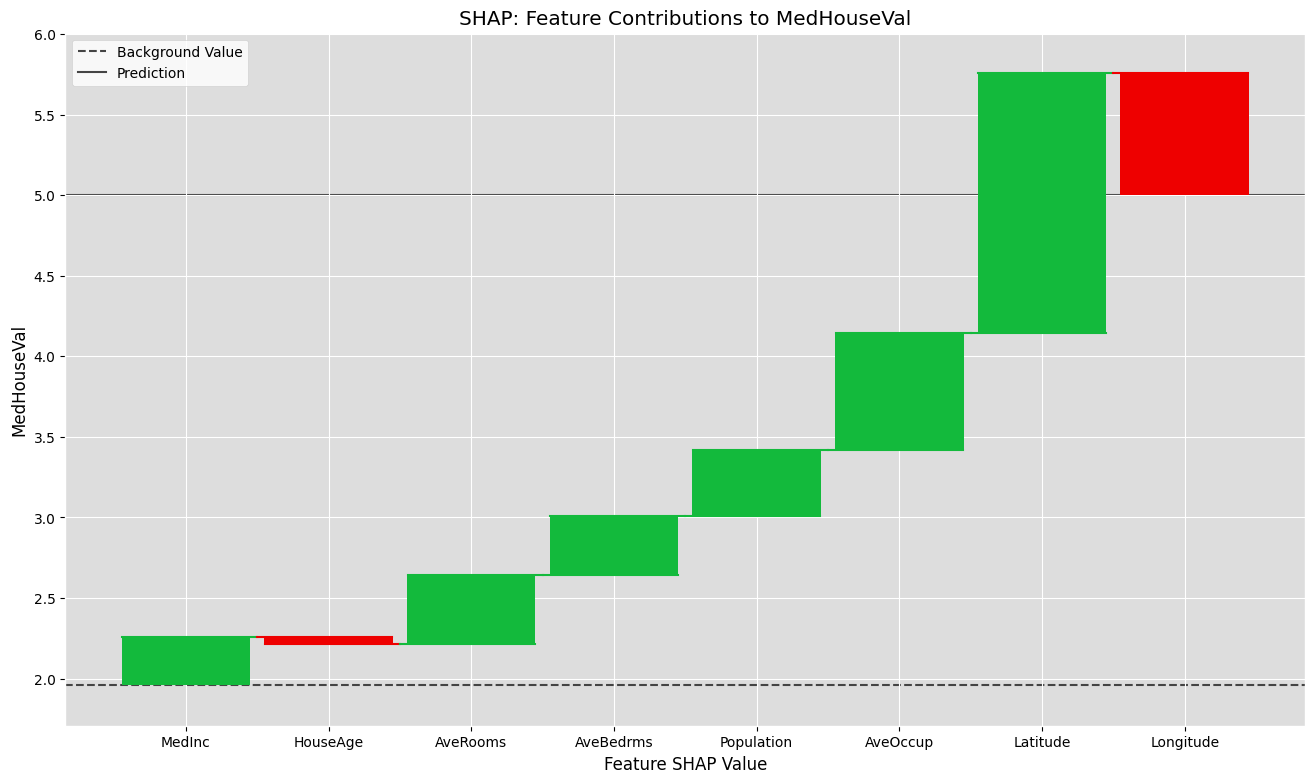

In [9]:
explanations.plot()

In [10]:
explanations.as_html()['MedHouseVal']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,1.956841,nan
1,MedInc,3.534100,3.843694,0.302831,0.417603
2,HouseAge,15.000000,25.770000,-0.047652,0.417603
3,AveRooms,5.681710,5.501786,0.429469,0.417603
4,AveBedrms,1.059382,1.100650,0.367612,0.417603
5,Population,747.000000,1622.840000,0.407360,0.417603
6,AveOccup,1.774347,2.919693,0.726651,0.417603
7,Latitude,33.100000,35.738600,1.616183,0.417603
8,Longitude,-117.310000,-119.693200,-0.759286,1.104874
